# Distinguishing different sports - using Keras

We will use the following directory structure.

In [42]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard
from keras import optimizers
from keras import backend as K

import numpy as np
np.set_printoptions(precision = 3)

import os
from PIL import Image
from IPython import display 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,12)

In [43]:
train_data_dir = 'data/train'
test_data_dir = 'data/test' 

classes = os.listdir(test_data_dir)
classes

['skating', 'xc_skiing', 'cycling', 'gymnastics', 'rowing', 'climbing']

In [44]:
# do this just once
#for img_class in classes:
#    img_paths = os.listdir(os.path.join(train_data_dir, img_class))
#    n_samples = len(img_paths)
#    print(img_class, n_samples)
#    images_to_move = img_paths[0:(round(n_samples/5))]
#    for file in images_to_move:
#        os.rename(os.path.join(train_data_dir, img_class, file), os.path.join(test_data_dir, img_class, file))

In [45]:
num_epochs = 20
batch_size = 20
learning_rate = 0.0001
decay = 1e-6

num_classes = len(os.listdir(test_data_dir))

model_exists = True
model_name = "cnn_keras_20epochs_batchnorm.h5"

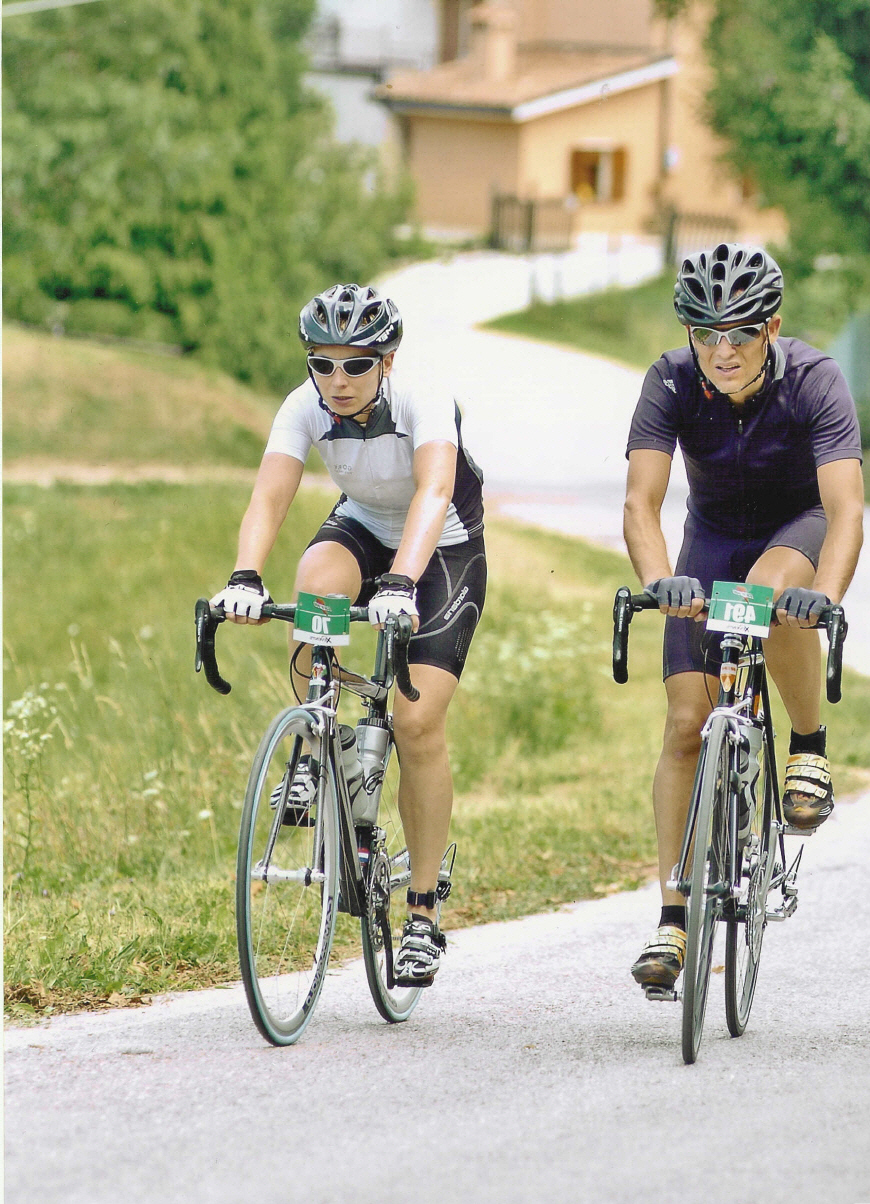

In [46]:
# display an example image
path = "data/train/cycling/n00451563_1000.JPEG"

img = load_img(path)
img

In [48]:
# get image as a numpy array
img = load_img(path)
img_array = img_to_array(img)  
img_array.shape

(1204, 870, 3)

In [49]:
img_array

array([[[ 233.,  246.,  229.],
        [ 235.,  250.,  211.],
        [ 139.,  152.,   96.],
        ..., 
        [ 100.,  131.,   89.],
        [ 102.,  132.,   94.],
        [ 102.,  128.,   89.]],

       [[ 239.,  244.,  237.],
        [ 244.,  253.,  222.],
        [ 127.,  141.,   82.],
        ..., 
        [  88.,  125.,   81.],
        [  97.,  130.,   87.],
        [ 103.,  130.,   89.]],

       [[ 241.,  244.,  235.],
        [ 244.,  250.,  222.],
        [ 124.,  138.,   79.],
        ..., 
        [  88.,  127.,   83.],
        [  89.,  126.,   82.],
        [  89.,  122.,   79.]],

       ..., 
       [[ 242.,  249.,  241.],
        [ 242.,  247.,  240.],
        [ 242.,  247.,  240.],
        ..., 
        [ 207.,  207.,  207.],
        [ 206.,  206.,  206.],
        [ 207.,  207.,  207.]],

       [[ 242.,  249.,  241.],
        [ 243.,  248.,  242.],
        [ 242.,  247.,  241.],
        ..., 
        [ 207.,  207.,  207.],
        [ 207.,  207.,  207.],
        [ 

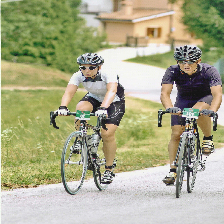

In [50]:
img = load_img(path, target_size=(224,224))
img

In [51]:
img_array = img_to_array(img)  
img_array.shape

(224, 224, 3)

We need to reshape the images to the shape required by Keras Conv layer, which is 4-dimensional.

In [52]:
img_array = np.expand_dims(img_array, axis=0)
img_array.shape

(1, 224, 224, 3)

Before we start, let's view some more instances of the classes...


In [53]:
def show_images(dir_path, n_images, cols):
    img_files = os.listdir(dir_path)
    images = [mpimg.imread(os.path.join(dir_path, file)) for file in img_files[:n_images]]
    fig = plt.figure(figsize = (2,2))

    for (n, img) in enumerate(images):
        ax = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(img)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

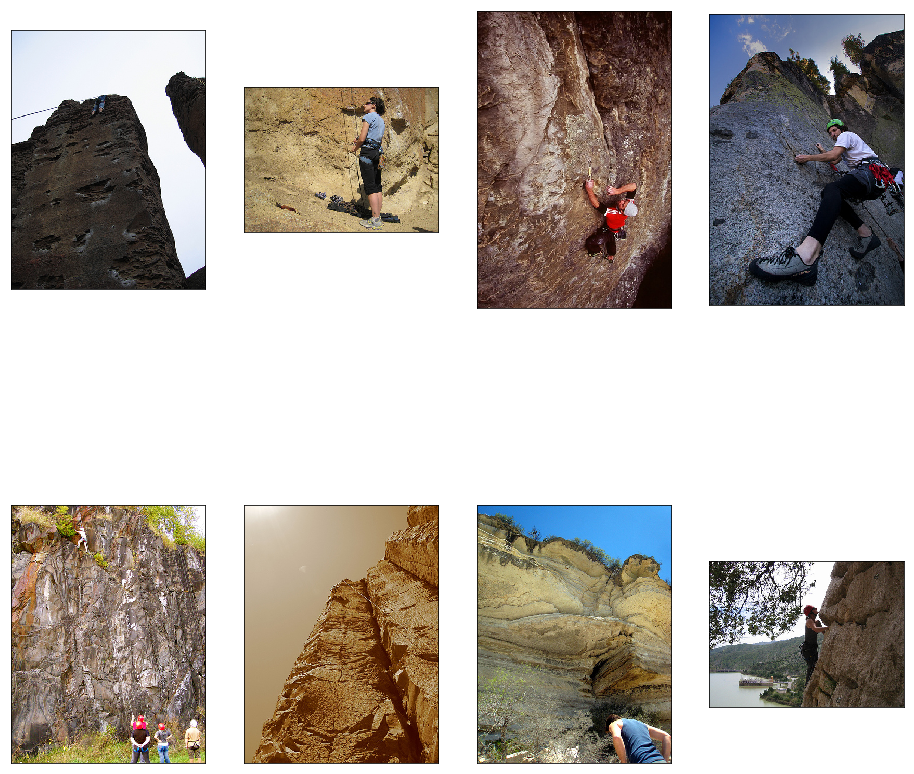

In [54]:
show_images("data/train/climbing/", 8, 2)

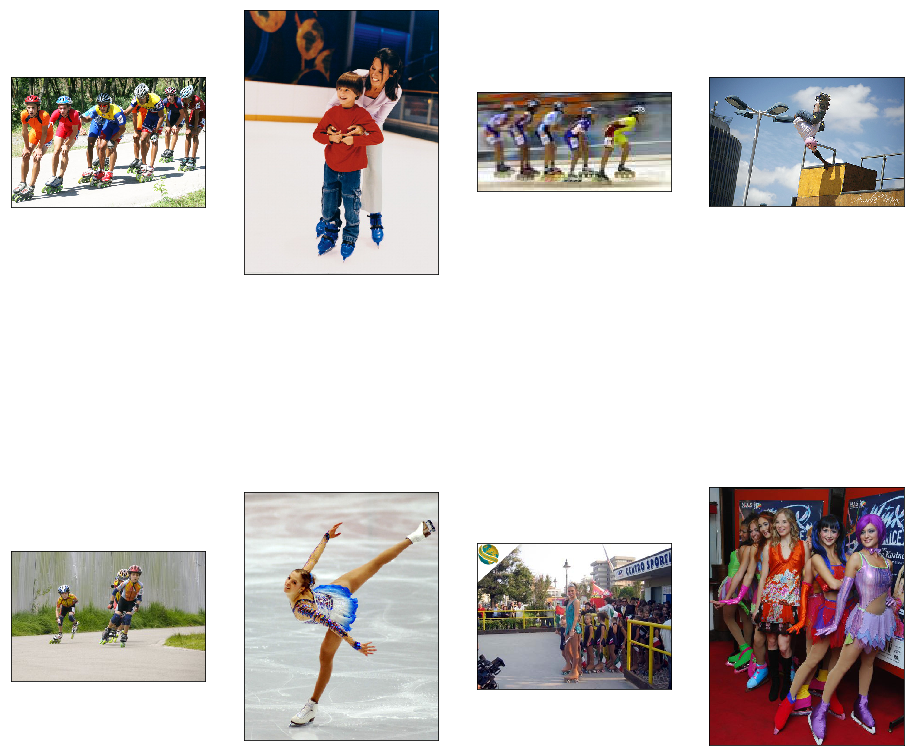

In [55]:
show_images("data/train/skating/", 8, 2)

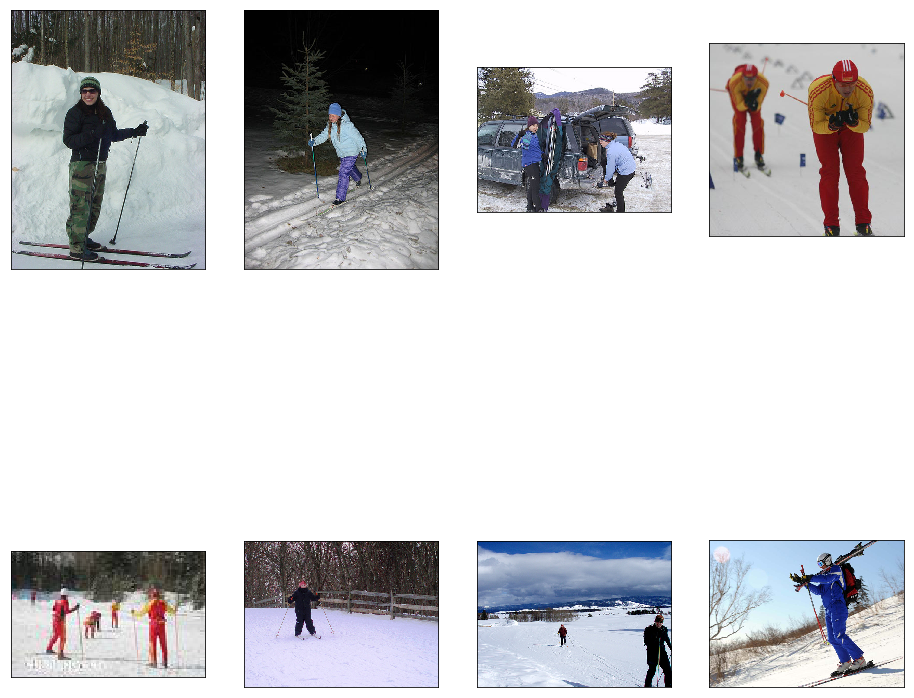

In [56]:
show_images("data/train/xc_skiing/", 8, 2)

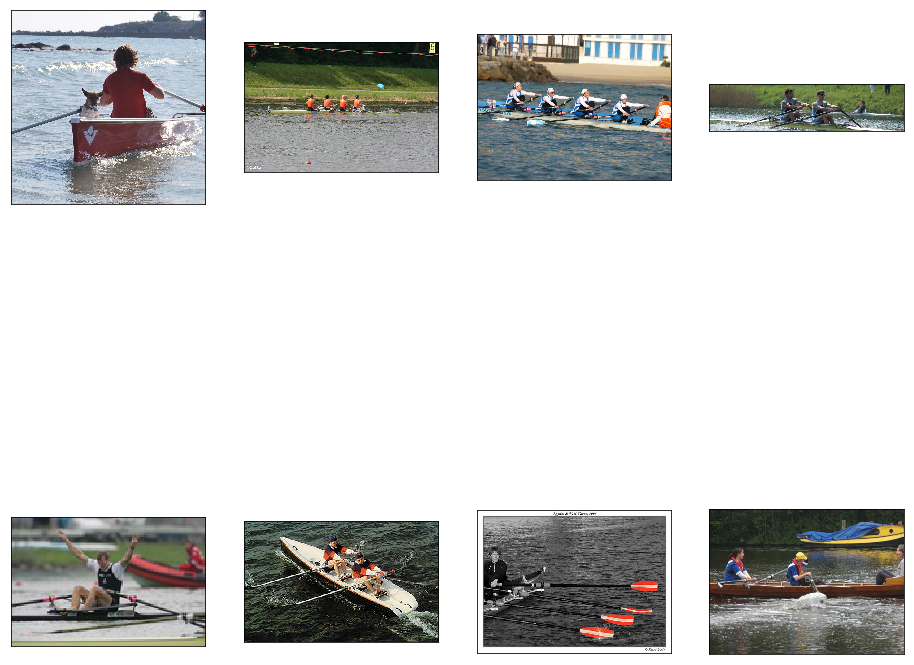

In [57]:
show_images("data/train/rowing/", 8, 2)

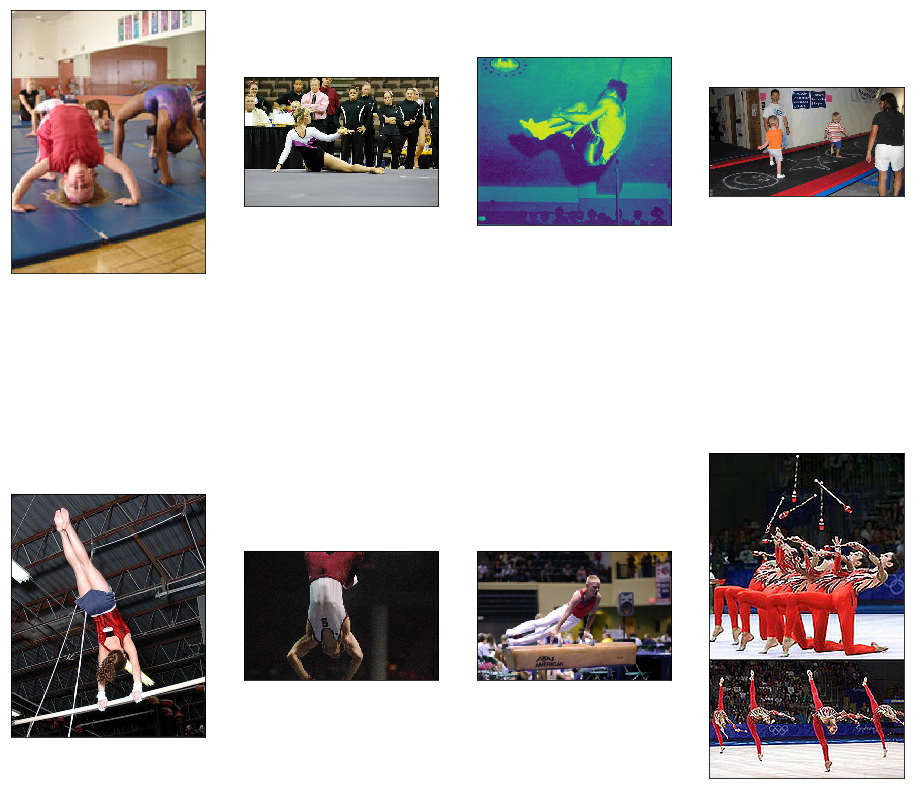

In [58]:
show_images("data/train/gymnastics/", 8, 2)

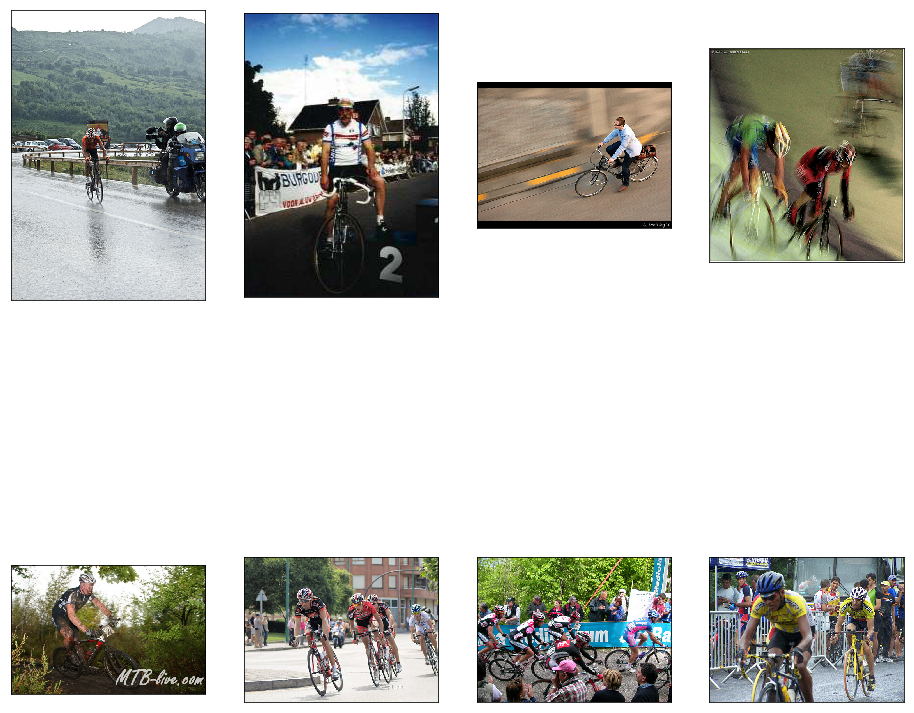

In [59]:
show_images("data/train/cycling/", 8, 2)

In [60]:
target_width = 224
target_height = 224
target_size = (target_height, target_width)

In [61]:
# Input shape
# 4D tensor with shape: (samples, channels, rows, cols) if data_format='channels_first' or
# 4D tensor with shape: (samples, rows, cols, channels) if data_format='channels_last'.
print(K.image_data_format())
input_shape = (target_height, target_width, 3)

channels_last


In [63]:
if not model_exists:
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding = "same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
   
    model.add(Conv2D(32, (3, 3), padding = "same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), padding = "same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3), padding = "same"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.rmsprop(lr = learning_rate, decay=decay),
                  metrics=['accuracy'])
    model.summary()


In [64]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [65]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 7096 images belonging to 6 classes.


In [66]:
train_generator.class_indices

{'climbing': 0,
 'cycling': 1,
 'gymnastics': 2,
 'rowing': 3,
 'skating': 4,
 'xc_skiing': 5}

In [67]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical')

Found 1775 images belonging to 6 classes.


In [68]:
test_generator.class_indices

{'climbing': 0,
 'cycling': 1,
 'gymnastics': 2,
 'rowing': 3,
 'skating': 4,
 'xc_skiing': 5}

In [69]:
class_dict = dict((v,k) for k,v in test_generator.class_indices.items())
class_dict

{0: 'climbing',
 1: 'cycling',
 2: 'gymnastics',
 3: 'rowing',
 4: 'skating',
 5: 'xc_skiing'}

In [70]:
n_class_freqs_test = {}
for img_class in class_dict.values():
    img_paths = os.listdir(os.path.join(test_data_dir, img_class))
    n_class_freqs_test[img_class] = len(img_paths)
print(n_class_freqs_test)

n_test = sum(n_class_freqs_test.values())
n_test

{'xc_skiing': 280, 'gymnastics': 390, 'cycling': 314, 'climbing': 290, 'rowing': 287, 'skating': 214}


1775

In [71]:
n_class_freqs_train = {}
for img_class in class_dict.values():
    img_paths = os.listdir(os.path.join(train_data_dir, img_class))
    n_class_freqs_train[img_class] = len(img_paths)
print(n_class_freqs_train)

n_train = sum(n_class_freqs_train.values())
n_train

{'xc_skiing': 1121, 'gymnastics': 1558, 'cycling': 1256, 'climbing': 1160, 'rowing': 1147, 'skating': 854}


7096

In [72]:
if model_exists:
    model = load_model(model_name)
    model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
__________

In [73]:
hist = None
if not model_exists:
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=n_train // batch_size,
        epochs=num_epochs,
        validation_data = test_generator,
        validation_steps = n_test // batch_size,
        callbacks = [EarlyStopping(patience = 2), TensorBoard(histogram_freq = 5, write_images = True)])
    
    model.save(model_name)

In [74]:
def plot_hist(hist):
    fig = plt.figure()
    # subplot(nrows, ncols, plot_number)
    ax1 = fig.add_subplot(121)
    ax1.plot(hist.history['loss'], 'c-')
    ax1.plot(hist.history['val_loss'], 'b')
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')

    ax2 = fig.add_subplot(122)
    ax2.plot(hist.history['acc'], 'c-')
    ax2.plot(hist.history['val_acc'], 'b')
    ax2.set_title('accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    plt.show()

In [75]:
if hist is not None: plot_hist(hist)

In [33]:
model.evaluate_generator(train_generator, steps =  n_train // batch_size)

[0.52892966914690487, 0.80409604799276013]

In [34]:
model.evaluate_generator(test_generator, steps =  n_test // batch_size)

[1.0728431178087539, 0.69545454565774312]

In [35]:
model.metrics_names

['loss', 'acc']

In [76]:
test_img_path = 'data/train/cycling/n00451563_10084.JPEG'
img = load_img(test_img_path, target_size=target_size) 
candidate = np.expand_dims(img_to_array(img)/255, axis=0)
pred, prob = model.predict_classes(candidate, verbose=0), model.predict_proba(candidate, batch_size=1, verbose=0)

print('Predicted class: {}'.format(class_dict[pred[0]]))
print('Class probabilities: {}'.format(prob[0]))


Predicted class: cycling
Class probabilities: [  7.175e-03   9.894e-01   3.050e-05   1.102e-03   1.976e-03   3.269e-04]


In [37]:
def score_img(img_path):
    img = load_img(img_path, target_size=target_size) 
    candidate = np.expand_dims(img_to_array(img)/255, axis=0)
    pred = model.predict_classes(candidate, verbose=0)
    return pred[0]

In [38]:
confusion_matrix_test = np.zeros((num_classes, num_classes), np.int32)
confusion_matrix_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int32)

In [39]:
for key, value in class_dict.items():
    print(key, value)
    preds = np.zeros(num_classes)
    class_dir = os.path.join(test_data_dir, value)
    for imgfile in os.listdir(class_dir):
        score = score_img(os.path.join(class_dir, imgfile))
        preds[score] = preds[score] + 1
        
    print(preds)
    confusion_matrix_test[key, : ] = preds

0 climbing
[ 236.   24.   13.   12.    1.    4.]
1 cycling
[  24.  251.   15.   17.    0.    7.]
2 gymnastics
[   3.   38.  309.   26.    4.   10.]
3 rowing
[  13.   26.   18.  225.    0.    5.]
4 skating
[ 12.  80.  46.  10.  14.  52.]
5 xc_skiing
[  13.   37.   12.   16.    4.  198.]


In [40]:
confusion_matrix_test

array([[236,  24,  13,  12,   1,   4],
       [ 24, 251,  15,  17,   0,   7],
       [  3,  38, 309,  26,   4,  10],
       [ 13,  26,  18, 225,   0,   5],
       [ 12,  80,  46,  10,  14,  52],
       [ 13,  37,  12,  16,   4, 198]], dtype=int32)

In [41]:
confusion_matrix_train = np.zeros((num_classes, num_classes), np.int32)

for key, value in class_dict.items():
    preds = np.zeros(num_classes)
    class_dir = os.path.join(train_data_dir, value)
    for imgfile in os.listdir(class_dir):
        score = score_img(os.path.join(class_dir, imgfile))
        preds[score] = preds[score] + 1        
    confusion_matrix_train[key, : ] = preds
    
confusion_matrix_train

array([[1060,   42,   34,   17,    1,    6],
       [  29, 1158,   32,   24,    3,   10],
       [  16,   59, 1395,   44,   18,   26],
       [  19,   59,   19, 1020,    2,   28],
       [  22,  305,  166,   29,  160,  172],
       [  21,   84,   68,   30,    6,  912]], dtype=int32)